### Sources used
1. EXAMPLE ON HOW TO IMPLEMENT THE DATASETS: https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html
2. LOOK AHEAD BIAS EXPLANATION: https://stats.stackexchange.com/questions/442739/look-ahead-bias-induced-by-standardization-of-a-time-series#:~:text=Yes%20this%20is%20considered%20a,will%20not%20have%20this%20information.
3. Simple yt vid explanation: https://www.youtube.com/watch?v=q_HS4s1L8UI&t=428s
4. Dataloader for time series task: https://stackoverflow.com/questions/57893415/pytorch-dataloader-for-time-series-task


Multi-Step LSTM Time Series Forecasting Models for Power Usage

(https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/)

LSTM model expects data to have the shape
[samples, timesteps, features]

example: A training dataset with 159 hours of data and 8 variables using 7 day prior CW, so the shape of the training dataset would be:
[159, 7, 8]

In [364]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from pytorch_forecasting import TimeSeriesDataSet
from tqdm.autonotebook import tqdm
import copy
from pathlib import Path
import warnings
import matplotlib.pyplot as plt
from helper_functions.engine import train
from sklearn.metrics import mean_absolute_error as mae
import torch
import numpy as np
import pandas as pd
import torch
from torch import nn
from copy import deepcopy as dc
import warnings
warnings.filterwarnings("ignore")

In [365]:
df = pd.read_csv("Datasets/Dataframes_one_ex_var/ModelBenchmark_dataframe.csv")
df.head(), df.shape

(                  Date  Price  FR Generation  FR Load
 0  2018-01-01 00:00:00   4.74        53625.0  56250.0
 1  2018-01-01 01:00:00   3.66        52398.0  54300.0
 2  2018-01-01 02:00:00   1.26        51825.0  53600.0
 3  2018-01-01 03:00:00 -20.10        50729.0  50000.0
 4  2018-01-01 04:00:00 -31.82        50719.0  47100.0,
 (43824, 4))

In [366]:
# Set Date as index
df.Date = pd.to_datetime(df.Date)

df.head()

,Date,Price,FR Generation,FR Load
0,2018-01-01 00:00:00,4.74,53625.0,56250.0
1,2018-01-01 01:00:00,3.66,52398.0,54300.0
2,2018-01-01 02:00:00,1.26,51825.0,53600.0
3,2018-01-01 03:00:00,-20.10,50729.0,50000.0
4,2018-01-01 04:00:00,-31.82,50719.0,47100.0


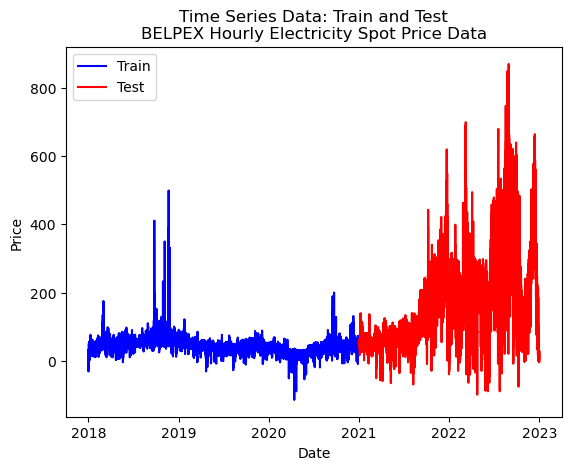

In [368]:
train_df = df[df['Date'] < '2021-01-01']
test_df = df[(df['Date'] >= '2021-01-01') & (df['Date'] <= '2022-12-31 23:00:00')]

# Plot train dataset in blue
plt.plot(train_df["Date"], train_df["Price"], color='blue', label='Train')

# Plot test dataset in red
plt.plot(test_df["Date"], test_df["Price"], color='red', label='Test')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Time Series Data: Train and Test\nBELPEX Hourly Electricity Spot Price Data')
plt.show()

In [338]:
# def prepare_dataframe_laggs(df, n_steps):
#     df = dc(df)
#     df.set_index("Date", inplace=True)

#     for i in range(1,n_steps+1):
#         df[f'Price(t-{i})'] = df["Price"].shift(i)

#     df.dropna(inplace=True)
#     return df

In [339]:
# Set Date as index
df.Date = pd.to_datetime(df.Date)
df.set_index("Date", inplace=True)

In [340]:
CW = 1095
train_last_index = df.index.get_loc('2021-01-01').start - 1
train_first_index = train_last_index - (CW *24)
df = df.iloc[train_first_index:,:]
df

,Price,FR Generation,FR Load
Date,,,
2018-01-01 23:00:00,13.02,66874.0,58500.0
2018-01-02 00:00:00,8.45,63261.0,57750.0
2018-01-02 01:00:00,5.09,61005.0,55200.0
2018-01-02 02:00:00,1.64,60342.0,54950.0
2018-01-02 03:00:00,1.41,60006.0,52150.0
...,...,...,...
2022-12-31 19:00:00,10.55,44648.0,45600.0
2022-12-31 20:00:00,5.22,43841.0,47700.0
2022-12-31 21:00:00,2.39,44578.0,50450.0


In [341]:
# add dummy variables for weekdays + 7 features
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, x in enumerate(names):
    df[x] = (df.index.get_level_values(0).weekday == i).astype(int)

# add lagged variables for price + exogenous variables + (92 + 72*N) features
def prepare_dataframe_laggs(df: pd.DataFrame, historical_price_laggs: list =  [1,2,3,7], historical_exo_laggs: list = [1,7]):
    df = dc(df)

    exo_var = df.columns[1:-7]

    laggs = []
    for i in historical_price_laggs:
        new_laggs = [x for x in list(range(i, 24*i)) if x not in list(range(i-1, 24*(i-1)))]
        laggs += new_laggs

    for i in laggs:
        df[f'Price(t-{i})'] = df["Price"].shift(i)

    laggs = []
    for i in historical_exo_laggs:
        new_laggs = [x for x in list(range(i, 24*i)) if x not in list(range(i-1, 24*(i-1)))]
        laggs += new_laggs

    for exo in exo_var:
        for j in laggs:
            df[f'{exo}(t-{j})'] = df[exo].shift(j)

    return df

historical_price_laggs = [1]
lagged_df = prepare_dataframe_laggs(df, historical_price_laggs=historical_price_laggs, historical_exo_laggs=[1,7])
lagged_df.dropna(inplace=True)
lagged_df.head()

,Price,FR Generation,FR Load,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,...,FR Load(t-158),FR Load(t-159),FR Load(t-160),FR Load(t-161),FR Load(t-162),FR Load(t-163),FR Load(t-164),FR Load(t-165),FR Load(t-166),FR Load(t-167)
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-08 22:00:00,45.19,78520.0,64550.0,1,0,0,0,0,0,0,...,62750.0,59100.0,55050.0,51900.0,50750.0,52150.0,54950.0,55200.0,57750.0,58500.0
2018-01-08 23:00:00,56.13,73413.0,67400.0,1,0,0,0,0,0,0,...,64450.0,62750.0,59100.0,55050.0,51900.0,50750.0,52150.0,54950.0,55200.0,57750.0
2018-01-09 00:00:00,36.50,70368.0,65200.0,0,1,0,0,0,0,0,...,66100.0,64450.0,62750.0,59100.0,55050.0,51900.0,50750.0,52150.0,54950.0,55200.0
2018-01-09 01:00:00,34.20,69237.0,62050.0,0,1,0,0,0,0,0,...,66900.0,66100.0,64450.0,62750.0,59100.0,55050.0,51900.0,50750.0,52150.0,54950.0
2018-01-09 02:00:00,31.75,68954.0,60950.0,0,1,0,0,0,0,0,...,68000.0,66900.0,66100.0,64450.0,62750.0,59100.0,55050.0,51900.0,50750.0,52150.0


In [342]:
lagged_df = lagged_df.iloc[:,:10+((len(historical_price_laggs)*24)-1)]
lagged_df.drop(df.columns[1:10],axis = 1, inplace=True)
lagged_df

,Price,Price(t-1),Price(t-2),Price(t-3),Price(t-4),Price(t-5),Price(t-6),Price(t-7),Price(t-8),Price(t-9),...,Price(t-14),Price(t-15),Price(t-16),Price(t-17),Price(t-18),Price(t-19),Price(t-20),Price(t-21),Price(t-22),Price(t-23)
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-08 22:00:00,45.19,50.00,40.70,50.00,50.00,70.00,64.93,53.89,40.97,46.61,...,46.20,44.95,42.93,30.03,17.10,12.91,13.42,15.11,15.15,18.91
2018-01-08 23:00:00,56.13,45.19,50.00,40.70,50.00,50.00,70.00,64.93,53.89,40.97,...,50.00,46.20,44.95,42.93,30.03,17.10,12.91,13.42,15.11,15.15
2018-01-09 00:00:00,36.50,56.13,45.19,50.00,40.70,50.00,50.00,70.00,64.93,53.89,...,59.53,50.00,46.20,44.95,42.93,30.03,17.10,12.91,13.42,15.11
2018-01-09 01:00:00,34.20,36.50,56.13,45.19,50.00,40.70,50.00,50.00,70.00,64.93,...,43.80,59.53,50.00,46.20,44.95,42.93,30.03,17.10,12.91,13.42
2018-01-09 02:00:00,31.75,34.20,36.50,56.13,45.19,50.00,40.70,50.00,50.00,70.00,...,44.00,43.80,59.53,50.00,46.20,44.95,42.93,30.03,17.10,12.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,10.55,22.09,27.93,26.91,14.88,16.70,3.98,1.07,1.45,0.96,...,0.00,-0.02,0.01,0.02,0.08,0.22,1.52,2.31,1.10,2.15
2022-12-31 20:00:00,5.22,10.55,22.09,27.93,26.91,14.88,16.70,3.98,1.07,1.45,...,0.00,0.00,-0.02,0.01,0.02,0.08,0.22,1.52,2.31,1.10
2022-12-31 21:00:00,2.39,5.22,10.55,22.09,27.93,26.91,14.88,16.70,3.98,1.07,...,0.76,0.00,0.00,-0.02,0.01,0.02,0.08,0.22,1.52,2.31


In [343]:
# lookback = 7
# lagged_df = prepare_dataframe_laggs(df, lookback)
# lagged_df.head(), lagged_df.shape

In [344]:
lagged_df_np = lagged_df.to_numpy()
lagged_df_np

array([[ 4.519e+01,  5.000e+01,  4.070e+01, ...,  1.511e+01,  1.515e+01,
         1.891e+01],
       [ 5.613e+01,  4.519e+01,  5.000e+01, ...,  1.342e+01,  1.511e+01,
         1.515e+01],
       [ 3.650e+01,  5.613e+01,  4.519e+01, ...,  1.291e+01,  1.342e+01,
         1.511e+01],
       ...,
       [ 2.390e+00,  5.220e+00,  1.055e+01, ...,  2.200e-01,  1.520e+00,
         2.310e+00],
       [ 1.300e-01,  2.390e+00,  5.220e+00, ...,  8.000e-02,  2.200e-01,
         1.520e+00],
       [-4.390e+00,  1.300e-01,  2.390e+00, ...,  2.000e-02,  8.000e-02,
         2.200e-01]])

In [345]:
lagged_df.head()

,Price,Price(t-1),Price(t-2),Price(t-3),Price(t-4),Price(t-5),Price(t-6),Price(t-7),Price(t-8),Price(t-9),...,Price(t-14),Price(t-15),Price(t-16),Price(t-17),Price(t-18),Price(t-19),Price(t-20),Price(t-21),Price(t-22),Price(t-23)
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-08 22:00:00,45.19,50.00,40.70,50.00,50.00,70.0,64.93,53.89,40.97,46.61,...,46.20,44.95,42.93,30.03,17.10,12.91,13.42,15.11,15.15,18.91
2018-01-08 23:00:00,56.13,45.19,50.00,40.70,50.00,50.0,70.00,64.93,53.89,40.97,...,50.00,46.20,44.95,42.93,30.03,17.10,12.91,13.42,15.11,15.15
2018-01-09 00:00:00,36.50,56.13,45.19,50.00,40.70,50.0,50.00,70.00,64.93,53.89,...,59.53,50.00,46.20,44.95,42.93,30.03,17.10,12.91,13.42,15.11
2018-01-09 01:00:00,34.20,36.50,56.13,45.19,50.00,40.7,50.00,50.00,70.00,64.93,...,43.80,59.53,50.00,46.20,44.95,42.93,30.03,17.10,12.91,13.42
2018-01-09 02:00:00,31.75,34.20,36.50,56.13,45.19,50.0,40.70,50.00,50.00,70.00,...,44.00,43.80,59.53,50.00,46.20,44.95,42.93,30.03,17.10,12.91


In [346]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Scaler 1
# Transform features by scaling each feature to a given range. 
scaler = MinMaxScaler(feature_range=(-1,1))
lagged_df_np = scaler.fit_transform(lagged_df_np)

# # Scaler 2
# scaler = RobustScaler().fit(lagged_df_np)
# lagged_df_np = scaler.transform(lagged_df_np)
# lagged_df_np


In [347]:
X = lagged_df_np[:, 1:]
y = lagged_df_np[:, 0]
X.shape, y.shape

((43634, 23), (43634,))

In [348]:
X = dc(np.flip(X, axis=1))
X

array([[-0.72783405, -0.73545843, -0.73553954, ..., -0.66479099,
        -0.68364916, -0.66479099],
       [-0.73545843, -0.73553954, -0.73896645, ..., -0.68364916,
        -0.66479099, -0.67454451],
       [-0.73553954, -0.73896645, -0.74000061, ..., -0.66479099,
        -0.67454451, -0.65236082],
       ...,
       [-0.76149486, -0.7630968 , -0.76573288, ..., -0.72138577,
        -0.74478612, -0.75559408],
       [-0.7630968 , -0.76573288, -0.76601677, ..., -0.74478612,
        -0.75559408, -0.76133264],
       [-0.76573288, -0.76601677, -0.76613844, ..., -0.75559408,
        -0.76133264, -0.76591538]])

In [349]:
split_index = int(len(X)*0.95)
split_index = lagged_df.index.get_loc('2021-01-01').start

In [350]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26114, 23), (17520, 23), (26114,), (17520,))

In [351]:
X_train = X_train.reshape((-1, X.shape[1], 1))
X_test = X_test.reshape((-1, X.shape[1], 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26114, 23, 1), (17520, 23, 1), (26114, 1), (17520, 1))

In [352]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([26114, 23, 1]),
 torch.Size([17520, 23, 1]),
 torch.Size([26114, 1]),
 torch.Size([17520, 1]))

In [353]:
from helper_functions.data_setup import TimeseriesDataset

# class TimeseriesDataset(Dataset):
#     def __init__(self, X, y):
#         self.X = X
#         self.y = y

#     def __len__(self):
#         return len(self.X)
    
#     def __getitem__(self, i):
#         return self.X[i],self.y[i]
    
train_dataset = TimeseriesDataset(X_train, y_train)
test_dataset = TimeseriesDataset(X_test, y_test)

In [354]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [355]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [356]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 23, 1]) torch.Size([16, 1])


In [357]:
from helper_functions.model_builder import LSTM

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [358]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training with help from engine.py
train(model=model,
             train_dataloader=train_loader,
             test_dataloader=test_loader,
             loss_fn=loss_function,
             optimizer=optimizer,
             epochs=num_epochs,
             device=device)

 10%|█         | 1/10 [00:04<00:37,  4.15s/it]

Epoch: 1 | train_loss: 0.0226 | train_MAE: 0.0661 | test_loss: 0.0692 | test_MAE: 0.1727


 20%|██        | 2/10 [00:08<00:33,  4.17s/it]

Epoch: 2 | train_loss: 0.0007 | train_MAE: 0.0186 | test_loss: 0.0567 | test_MAE: 0.1508


 30%|███       | 3/10 [00:12<00:29,  4.15s/it]

Epoch: 3 | train_loss: 0.0007 | train_MAE: 0.0180 | test_loss: 0.0465 | test_MAE: 0.1344


 40%|████      | 4/10 [00:16<00:24,  4.11s/it]

Epoch: 4 | train_loss: 0.0006 | train_MAE: 0.0171 | test_loss: 0.0375 | test_MAE: 0.1193


 50%|█████     | 5/10 [00:20<00:20,  4.14s/it]

Epoch: 5 | train_loss: 0.0006 | train_MAE: 0.0164 | test_loss: 0.0292 | test_MAE: 0.1038


 60%|██████    | 6/10 [00:24<00:16,  4.14s/it]

Epoch: 6 | train_loss: 0.0005 | train_MAE: 0.0155 | test_loss: 0.0242 | test_MAE: 0.0944


 70%|███████   | 7/10 [00:29<00:12,  4.15s/it]

Epoch: 7 | train_loss: 0.0005 | train_MAE: 0.0147 | test_loss: 0.0195 | test_MAE: 0.0836


 80%|████████  | 8/10 [00:33<00:08,  4.15s/it]

Epoch: 8 | train_loss: 0.0004 | train_MAE: 0.0139 | test_loss: 0.0170 | test_MAE: 0.0789


 90%|█████████ | 9/10 [00:37<00:04,  4.20s/it]

Epoch: 9 | train_loss: 0.0004 | train_MAE: 0.0132 | test_loss: 0.0137 | test_MAE: 0.0690


100%|██████████| 10/10 [00:41<00:00,  4.16s/it]

Epoch: 10 | train_loss: 0.0004 | train_MAE: 0.0126 | test_loss: 0.0118 | test_MAE: 0.0641


{'train_loss': [0.02263197618456736,
  0.000720435707260363,
  0.000672723834437577,
  0.0006172106784885459,
  0.0005692755266613343,
  0.0005178559706217856,
  0.0004771736157084664,
  0.00044174947512860905,
  0.0004087351475278684,
  0.0003817944436886779],
 'train_acc': [0.06605849609997144,
  0.01857123581096028,
  0.017954388398401078,
  0.017124904131440393,
  0.016391395678457422,
  0.015455909718948132,
  0.014677899016497402,
  0.01390689727037561,
  0.013207148914541923,
  0.012587846638332534],
 'test_loss': [0.06922607277177466,
  0.05666884994932336,
  0.04654066474284588,
  0.037511935337935946,
  0.0292434225252114,
  0.024216862706079194,
  0.019510092986851944,
  0.017043640268930675,
  0.013659173718634648,
  0.011849298019286872],
 'test_acc': [0.17267261306716972,
  0.15081104352968197,
  0.13442669655430262,
  0.11933500417869657,
  0.103792112300249,
  0.09444095776437625,
  0.08358097720091746,
  0.07885381519352193,
  0.0689740606570897,
  0.06405542455273404]

In [359]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], X.shape[1]+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])

dummies = np.zeros((X_train.shape[0], X.shape[1]+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
print("Train MAE", mae(new_y_train, train_predictions))

Train MAE 5.776481828597018


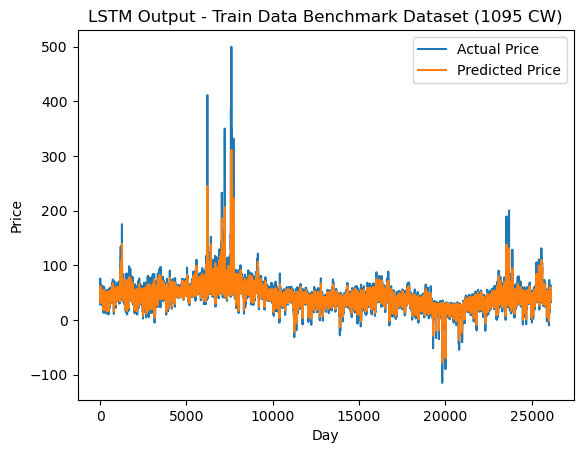

In [360]:
plt.plot(new_y_train, label="Actual Price")
plt.plot(train_predictions, label='Predicted Price')
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("LSTM Output - Train Data Benchmark Dataset (1095 CW)")
plt.legend()
plt.show()

In [361]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], X.shape[1]+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:,0])
test_predictions

dummies = np.zeros((X_test.shape[0], X.shape[1]+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
print("Test MAE", mae(new_y_test, test_predictions))

Test MAE 31.589252785845165


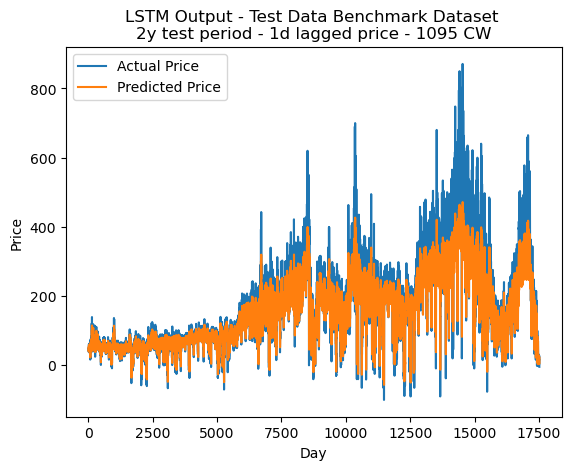

In [363]:
plt.plot(new_y_test, label="Actual Price")
plt.plot(test_predictions, label='Predicted Price')
plt.xlabel("Day")
plt.ylabel("Price")
plt.title(f"LSTM Output - Test Data Benchmark Dataset \n2y test period - 1d lagged price - {CW} CW")
plt.legend()
plt.show()